# Sizing of pods' memory request - preprod / nlp-data

In [100]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
from stats.stats_service import StatsService

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load a time series from disk

In [101]:
stats_service = StatsService(name="Memory MiB")
stats_service.load_time_series(path="data/nlp-data/mem_usage-60d.json")
# stats_service.load_time_series(path="data/mem_usage.json")

## Signal processing
- Smoothing with the _moving average_ approach
  - `window_size=11` means an averaging window of 10 time steps, that is 300s
- Flooring of lower values
  - The threshold is set so that we get a mono-variate distribution of higher peak values

In [102]:
from stats import smoothing
mem_threshold = 3000 # MiB
# stats_service.time_series.interpolate(step_sec=5, in_place=True)
stats_service.floor(threshold=mem_threshold);

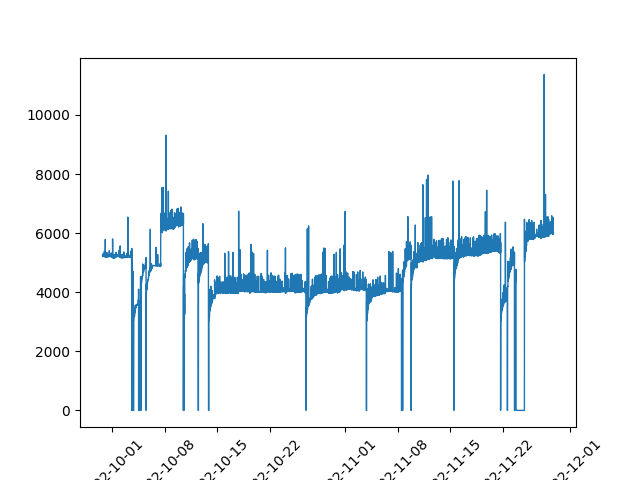

In [103]:
fig, ax = plt.subplots()
ax.plot(stats_service.time_series.time, stats_service.time_series.resource, linewidth=1.0)
plt.xticks(rotation = 45)
plt.show()

## CPU Peak values

In [104]:
# Find peaks
peaks = stats_service.get_peaks()

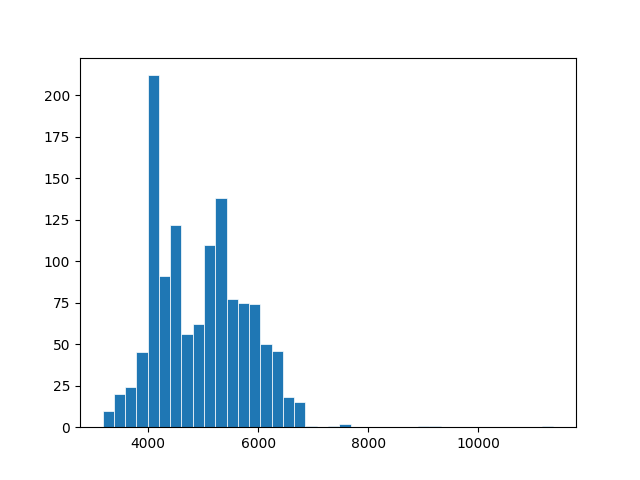

In [105]:
peaks.plots.histogram(bins=40)

## Percentiles
### Non-parametric
The percentiles are computed with a **non-parametric** approach. The assessment is not sensitive to the numerical method.

💡 These non-parametric approach are bounded to the sample range. Using a distribution model would allow a more "robust" result, given a proper determination of the model.

In [106]:
import pandas as pd
percents = [50, 75, 90, 95, 99, 99.9]
methods = [
    "linear",
    "inverted_cdf",
    "averaged_inverted_cdf",
    "closest_observation",
    "interpolated_inverted_cdf",
    "hazen",
    "weibull",
    "median_unbiased",
    "normal_unbiased",
    "lower",
    "higher",
    "midpoint",
    "nearest",
]

records = []
for method in methods:
    percentile_res = peaks.percentiles(percents, method=method)
    records.append({f"q-{perc_val}": quant_val for perc_val, quant_val in zip(percents, percentile_res)})
    
df = pd.DataFrame(records, index=methods)
display(df)
display(df.describe())
print("max = ", stats_service.time_series.resource.max(), "MiB")

,q-50,q-75,q-90,q-95,q-99,q-99.9
linear,4969.886719,5564.680664,6116.691016,6334.440430,6724.032383,9252.414328
inverted_cdf,4969.609375,5563.636719,6116.925781,6334.773438,6733.835938,9314.117188
averaged_inverted_cdf,4969.886719,5565.724609,6116.925781,6334.773438,6733.835938,9314.117188
closest_observation,4969.609375,5563.636719,6116.925781,6334.167969,6714.613281,9314.117188
interpolated_inverted_cdf,4969.609375,5563.636719,6116.456250,6334.410156,6723.840156,9252.168500
hazen,4969.886719,5565.724609,6117.218750,6334.712891,6733.451484,9824.261906
weibull,4969.886719,5566.768555,6117.609375,6336.146094,6751.593125,10850.722449
median_unbiased,4969.886719,5566.072591,6117.348958,6334.969531,6739.251250,10166.415421
normal_unbiased,4969.886719,5565.985596,6117.316406,6334.822461,6737.708516,10080.877042
lower,4969.609375,5563.636719,6114.578125,6334.167969,6714.613281,9068.289062


,q-50,q-75,q-90,q-95,q-99,q-99.9
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,4969.844050,5565.129025,6116.738442,6334.676653,6729.188398,9558.225982
std,0.191017,1.411654,0.795481,0.519713,11.090264,519.956904
min,4969.609375,5563.636719,6114.578125,6334.167969,6714.613281,9068.289062
25%,4969.609375,5563.636719,6116.691016,6334.410156,6723.840156,9252.414328
50%,4969.886719,5565.724609,6116.925781,6334.712891,6733.451484,9314.117188
75%,4969.886719,5565.985596,6117.218750,6334.773438,6733.835938,9824.261906
max,4970.164062,5567.812500,6117.609375,6336.146094,6751.593125,10850.722449


max =  11371.15234375 MiB


# Conclusion
Peak value statistics is not suitable for  assessing the request.
| request | limit    |
|---------|----------|
|6000 MiB | 12000 MiB|